<a href="https://colab.research.google.com/github/GuidoGiacomoMussini/Image_BORN/blob/main/Adjacency_Matrix_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opencv-python

In [ ]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as progress_bar
import matplotlib.pyplot as plt
from google.colab import drive
from collections import Counter
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
drive.mount('/content/drive')

#born

In [ ]:
import scipy.sparse
import numpy
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import _check_sample_weight
from sklearn.utils.multiclass import unique_labels
from sklearn.exceptions import NotFittedError

In [ ]:
class BornClassifier(ClassifierMixin, BaseEstimator):
    """Scikit-learn implementation of Born's Classifier

    This class is compatible with the [scikit-learn](https://scikit-learn.org) ecosystem.
    It supports both dense and sparse input and GPU-accelerated computing via [CuPy](https://cupy.dev).
    This classifier is suitable for classification with non-negative feature vectors.
    The data `X` are treated as unnormalized probability distributions.

    Parameters
    ----------
    a : float
        Amplitude. Must be strictly positive.
    b : float
        Balance. Must be non-negative.
    h : float
        Entropy. Must be non-negative.

    Attributes
    ----------
    gpu_ : bool
        Whether the model was fitted on GPU.
    corpus_ : array-like of shape (n_features_in_, n_classes)
        Fitted corpus.
    classes_ : ndarray of shape (n_classes,)
        Unique classes labels.
    n_features_in_ : int
        Number of features seen during `fit`.

    """

    def __init__(self, a=0.5, b=1., h=1.):
        self.a = a
        self.b = b
        self.h = h

    def fit(self, X, y, sample_weight=None):
        """Fit the classifier according to the training data X, y.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where `n_samples` is the number of samples
            and `n_features` is the number of features.
        y : array-like of shape (n_samples,) or (n_samples, n_classes)
            Target values. If 2d array, this is the probability
            distribution over the `n_classes` for each of the `n_samples`.
        sample_weight : array-like of shape (n_samples,)
            Array of weights that are assigned to individual samples.
            If not provided, then each sample is given unit weight.

        Returns
        -------
        self : object
            Returns the instance itself.

        """
        attrs = [
            "gpu_",
            "corpus_",
            "classes_",
            "n_features_in_"
        ]

        for attr in attrs:
            if hasattr(self, attr):
                delattr(self, attr)

        return self.partial_fit(X, y, classes=y, sample_weight=sample_weight)

    def partial_fit(self, X, y, classes=None, sample_weight=None):
        """Incremental fit on a batch of samples.

        This method is expected to be called several times consecutively on different chunks of a dataset so
        as to implement out-of-core or online learning.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where `n_samples` is the number of samples
            and `n_features` is the number of features.
        y : array-like of shape (n_samples,) or (n_samples, n_classes)
            Target values. If 2d array, this is the probability
            distribution over the `n_classes` for each of the `n_samples`.
        classes : array-like of shape (n_classes,)
            List of all the classes that can possibly appear in the `y` vector.
            Must be provided at the first call to `partial_fit`, can be omitted in subsequent calls.
        sample_weight : array-like of shape (n_samples,)
            Array of weights that are assigned to individual samples.
            If not provided, then each sample is given unit weight.

        Returns
        -------
        self : object
            Returns the instance itself.

        """
        X, y = self._sanitize(X, y)

        first_call = self._check_partial_fit_first_call(classes)
        if first_call:
            self.corpus_ = 0
            self.n_features_in_ = X.shape[1]

        if not self._check_encoded(y):
            y = self._one_hot_encoding(y)

        if sample_weight is not None:
            sample_weight = self._check_sample_weight(sample_weight, X)
            y = self._multiply(y, sample_weight.reshape(-1, 1))

        self.corpus_ += X.T @ self._multiply(y, self._power(self._sum(X, axis=1), -1))

        return self

    def predict(self, X):
        """Perform classification on the test data X.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Test data, where `n_samples` is the number of samples
            and `n_features` is the number of features.

        Returns
        -------
        y : ndarray of shape (n_samples,)
            Predicted target classes for `X`.

        """
        proba = self.predict_proba(X)
        idx = self._dense().argmax(proba, axis=1)

        return self.classes_[idx]

    def predict_proba(self, X):
        """Return probability estimates for the test data X.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Test data, where `n_samples` is the number of samples
            and `n_features` is the number of features.

        Returns
        -------
        y : ndarray of shape (n_samples, n_classes)
            Returns the probability of the samples for each class in the model.
            The columns correspond to the classes in sorted order, as they appear in the attribute `classes_`.

        """
        self._check_fitted()

        X = self._sanitize(X)
        u = self._power(self._power(X, self.a) @ self._weights(), 1. / self.a)
        y = self._normalize(u, axis=1)

        if self._sparse().issparse(y):
            y = y.todense()

        return self._dense().asarray(y)

    def explain(self, X=None, sample_weight=None):
        r"""Global and local explanation

        For each test vector $`x`$, the $`a`$-th power of the unnormalized probability for the $`k`$-th class is
        given by the matrix product:

        ```math
        u_k^a = \sum_j W_{jk}x_j^a
        ```
        where $`W`$ is a matrix of non-negative weights that generally depends on the model's
        hyper-parameters ($`a`$, $`b`$, $`h`$). The classification probabilities are obtained by
        normalizing $`u`$ such that it sums up to $`1`$.

        This method returns global or local feature importance weights, depending on `X`:

        - When `X` is not provided, this method returns the global weights $`W`$.

        - When `X` is a single sample,
        this method returns a matrix of entries $`(j,k)`$ where each entry is given by $`W_{jk}x_j^a`$.

        - When `X` contains multiple samples,
        then the values above are computed for each sample and this method returns their weighted sum.
        By default, each sample is given unit weight.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Test data, where `n_samples` is the number of samples
            and `n_features` is the number of features. If not provided,
            then global weights are returned.
        sample_weight : array-like of shape (n_samples,)
            Array of weights that are assigned to individual samples.
            If not provided, then each sample is given unit weight.

        Returns
        -------
        E : array-like of shape (n_features, n_classes)
            Returns the feature importance for each class in the model.
            The columns correspond to the classes in sorted order, as they appear in the attribute `classes_`.

        """
        self._check_fitted()

        if X is None:
            return self._weights()

        X = self._sanitize(X)
        X = self._normalize(X, axis=1)
        X = self._power(X, self.a)

        if sample_weight is not None:
            sample_weight = self._check_sample_weight(sample_weight, X)
            X = self._multiply(X, sample_weight.reshape(-1, 1))

        return self._multiply(self._weights(), self._sum(X, axis=0).T)

    def _dense(self):
        return  numpy

    def _sparse(self):
        return scipy.sparse

    def _weights(self):
        P_jk = self.corpus_
        if self.b != 0:
            P_jk = self._multiply(P_jk, self._power(self._sum(self.corpus_, axis=0), -self.b))
        if self.b != 1:
            P_jk = self._multiply(P_jk, self._power(self._sum(self.corpus_, axis=1), self.b-1))

        W_jk = self._power(P_jk, self.a)
        if self.h != 0 and len(self.classes_) > 1:
            P_jk = self._normalize(P_jk, axis=1)
            H_j = 1 + self._sum(self._multiply(P_jk, self._log(P_jk)), axis=1) / self._dense().log(P_jk.shape[1])
            W_jk = self._multiply(W_jk, self._power(H_j, self.h))

        return W_jk

    def _sum(self, x, axis):
        if self._sparse().issparse(x):
            return x.sum(axis=axis)

        return self._dense().asarray(x).sum(axis=axis, keepdims=True)

    def _multiply(self, x, y):
        if self._sparse().issparse(x):
            return x.multiply(y).tocsr()

        if self._sparse().issparse(y):
            return y.multiply(x).tocsr()

        return self._dense().multiply(x, y)

    def _power(self, x, p):
        x = x.copy()

        if self._sparse().issparse(x):
            x.data = self._dense().power(x.data, p)

        else:
            nz = self._dense().nonzero(x)
            x[nz] = self._dense().power(x[nz], p)

        return x

    def _log(self, x):
        x = x.copy()

        if self._sparse().issparse(x):
            x.data = self._dense().log(x.data)

        else:
            nz = self._dense().nonzero(x)
            x[nz] = self._dense().log(x[nz])

        return x

    def _normalize(self, x, axis, p=1.):
        s = self._sum(x, axis)
        n = self._power(s, -p)

        return self._multiply(x, n)

    def _sanitize(self, X, y="no_validation"):
        only_X = isinstance(y, str) and y == "no_validation"

        gpu = self._check_gpu(X=X, y=y if not only_X else None)
        if getattr(self, "gpu_", None) is None:
            self.gpu_ = gpu

        elif self.gpu_ != gpu:
            raise ValueError(
                "X is not on the same device (CPU/GPU) as on last call "
                "to partial_fit, was: %r" % (self.gpu_, ))

        if not self.gpu_:
            kwargs = {
                "accept_sparse": "csr",
                "reset": False,
                "dtype": (numpy.float32, numpy.float64)
            }

            if only_X:
                X = super()._validate_data(X=X, **kwargs)

            else:
                X, y = super()._validate_data(X=X, y=y, multi_output=self._check_encoded(y), **kwargs)

            if not self._check_non_negative(X):
                raise ValueError("X must contain non-negative values")

        return X if only_X else (X, y)

    def _unique_labels(self, y):
        if self._check_encoded(y):
            return self._dense().arange(0, y.shape[1])

        elif self.gpu_:
            return self._dense().unique(y)

        else:
            return unique_labels(y)

    def _one_hot_encoding(self, y):
        classes = self.classes_
        n, m = len(y), len(classes)

        if self.gpu_:
            y = y.get()
            classes = classes.get()

        unseen = set(y) - set(classes)
        if unseen:
            raise ValueError(
                "`classes=%r` were not allowed on first call "
                "to partial_fit" % (unseen, ))

        idx = {c: i for i, c in enumerate(classes)}
        col = self._dense().array([idx[c] for c in y])
        row = self._dense().array(range(0, n))
        val = self._dense().ones(n)

        return self._sparse().csr_matrix((val, (row, col)), shape=(n, m))

    def _check_encoded(self, y):
        return self._sparse().issparse(y) or (getattr(y, "ndim", 0) == 2 and y.shape[1] > 1)

    def _check_non_negative(self, X):
        if self._sparse().issparse(X):
            if self._dense().any(X.data < 0):
                return False

        elif self._dense().any(X < 0):
            return False

        return True

    def _check_sample_weight(self, sample_weight, X):
        if self.gpu_:
            return sample_weight

        return _check_sample_weight(sample_weight=sample_weight, X=X)

    def _check_partial_fit_first_call(self, classes):
        if getattr(self, "classes_", None) is None and classes is None:
            raise ValueError("classes must be passed on the first call to partial_fit")

        elif classes is not None:
            classes = self._unique_labels(classes)

            if getattr(self, "classes_", None) is not None:
                if not self._dense().array_equal(self.classes_, classes):
                    raise ValueError(
                        "`classes=%r` is not the same as on last call "
                        "to partial_fit, was: %r" % (classes, self.classes_))

            else:
                self.classes_ = classes
                return True

        return False

    def _check_gpu(self, X, y=None):
        return False

    def _check_fitted(self):
        if getattr(self, "corpus_", None) is None:
            raise NotFittedError(
                f"This {self.__class__.__name__} instance is not fitted yet. "
                "Call 'fit' with appropriate arguments before using this estimator")

    def _more_tags(self):
        return {
            'requires_y': True,
            'requires_positive_X': True,
            'X_types': ['2darray', 'sparse'],
            '_xfail_checks': {
                'check_classifiers_classes':
                    'This is a pathological data set for BornClassifier. '
                    'For some specific cases, it predicts less classes than expected',
                'check_classifiers_train':
                    'Test fails because of negative values in X'
            }
        }

#functions

In [ ]:
def one_hot_encode(number, column):
    # Creiamo una lista di 7 zeri (da 0 a 6)
    encoding = [0] * len(np.unique(column))
    # Impostiamo a 1 la posizione corrispondente al numero
    encoding[number] = 1
    return encoding

In [ ]:
def apply_threshold(img, threshold, upper = True):
    thresholded_array = np.copy(img)
    thresholded_array[thresholded_array < threshold] = 0
    if upper:
      thresholded_array[thresholded_array >= threshold] = 1
    return thresholded_array

# data

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/Tesi/MEDICAL IMAGING/'
file_ = 'Skin_Cancer.h5'
#file_ = 'Skin_Cancer_binary.h5'
df = pd.read_hdf(path+file_, 'df')
df.head()

df['label_bin'] = [ one_hot_encode(lab, df.label) for lab in df['label']]

In [ ]:
Counter(df.label)

Counter({2: 1099, 5: 6705, 3: 115, 4: 1113, 6: 142, 1: 514, 0: 327})

In [ ]:
# #grayscale + norm
# df['grayscale'] = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) / 255.0 for img in df.image]
# df['adjM'] = [apply_threshold(img, 0.5).flatten() for img in progress_bar(df.grayscale)]
# from sklearn.utils import shuffle
# df_shuffled = pd.DataFrame()
# df_shuffled = shuffle(df, random_state=42).reset_index(drop=True)
# split_index = int(len(df_shuffled) * 0.7)
# df_train = df_shuffled[:split_index].reset_index(drop=True)
# df_test = df_shuffled[split_index:].reset_index(drop=True)

# classifier = BornClassifier()
# classifier.fit(np.array(list(df_train.adjM)), np.array(list(df_train.label_bin)))

# # Make predictions on the test set
# pred = [int(classifier.predict(test.reshape(1, -1))) for test in df_test.adjM]

# np.mean([1 if np.argmax(df_test.label_bin[i]) == pred[i] else 0 for i in range(len(pred))])

In [ ]:
accuracies, cf = [], {}
hp = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9] #try with different cutoffs

#train-test split
df_train, df_test = train_test_split(df, test_size=0.3, random_state=19, stratify=df['label'])
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

#results for each hp value
for cutoff in progress_bar(hp):
  #grayscale and cutoff
  df_train['grayscale'] = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) / 255.0 for img in df_train.image]
  df_train['adjM'] = [apply_threshold(img, cutoff).flatten() for img in df_train.grayscale]

  df_test['grayscale'] = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) / 255.0 for img in df_test.image]
  df_test['adjM'] = [apply_threshold(img, cutoff).flatten() for img in df_test.grayscale]

  #Born
  classifier = BornClassifier()
  classifier.fit(np.array(list(df_train.adjM)), np.array(list(df_train.label_bin)))

  # Make predictions on the test set
  pred = [int(classifier.predict(test.reshape(1, -1))) for test in df_test.adjM]

  accuracies.append(accuracy_score(df_test.label, pred))
  cf[cutoff] = confusion_matrix(df_test.label, pred)

  0%|          | 0/9 [00:00<?, ?it/s]

In [ ]:
results = pd.DataFrame({'hp': hp, 'accuracy': accuracies}) #.sort_values(by=['accuracy'], ascending = False)
results

In [ ]:
#best confusion matrix
cf[np.argmax(results.accuracy)/10]

#Comparazione

In [ ]:
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

classifiers = {
    "RandomForest": RandomForestClassifier(),
    "LogisticRegression": LogisticRegression(),
    "MultinomialNB": MultinomialNB(),
    "KNeighbors": KNeighborsClassifier(),
    "SVC": SVC(),
    "DecisionTree": DecisionTreeClassifier(),
    "BORN": BornClassifier()
}

In [ ]:
#import the 3 datasets
path = '/content/drive/MyDrive/Colab Notebooks/Tesi/MEDICAL IMAGING/'
Bc = 'Brain_cancer.h5'
isic_m = 'Skin_Cancer_64.h5'
isic_b = 'Skin_Cancer_binary_64.h5'

df_bc = pd.read_hdf(path+Bc, 'df')
df_bc.name = 'brain_cancer'
df_isic_m = pd.read_hdf(path+isic_m, 'df')
df_isic_m.name = 'isic_multiclass'
df_isic_b = pd.read_hdf(path+isic_b, 'df')
df_isic_b.name = 'isic_binary'

df_list = [df_isic_m, df_isic_b, df_bc]

In [ ]:
#select a cutoff
cutoff = 0.5
dict_isic_b, dict_isic_m, dict_isic_bc = {}, {}, {}

isic binary

In [ ]:
df = df_isic_b

df['grayscale'] = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) / 255.0 for img in df.image]
df['adjM'] = [apply_threshold(img, cutoff).flatten() for img in df.grayscale]

df_train, df_test = train_test_split(df, test_size=0.3, random_state=19, stratify=df['label'])
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

#ISIC_BINARY
for name, model in progress_bar(classifiers.items()):

  model.fit(np.array(list(df_train.adjM)), np.array(list(df_train.label)))
  preds = model.predict(np.array(list(df_test.adjM)))
  accuracy = sklearn.metrics.accuracy_score(df_test.label, preds)
  dict_isic_b[name] = accuracy

isic multiclass

In [ ]:
df = df_isic_m

df['grayscale'] = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) / 255.0 for img in df.image]
df['adjM'] = [apply_threshold(img, cutoff).flatten() for img in df.grayscale]

df_train, df_test = train_test_split(df, test_size=0.3, random_state=19, stratify=df['label'])
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

#ISIC_MULTICLASS
for name, model in progress_bar(classifiers.items()):

  model.fit(np.array(list(df_train.adjM)), np.array(list(df_train.label)))
  preds = model.predict(np.array(list(df_test.adjM)))
  accuracy = sklearn.metrics.accuracy_score(df_test.label, preds)
  dict_isic_m[name] = accuracy

brain cancer

In [ ]:
df = df_bc

df['adjM'] = [apply_threshold(img, cutoff).flatten() for img in df.image]

df_train, df_test = train_test_split(df, test_size=0.3, random_state=19, stratify=df['label'])
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

#BRAIN CANCER
for name, model in progress_bar(classifiers.items()):

  model.fit(np.array(list(df_train.adjM)), np.array(list(df_train.label)))
  preds = model.predict(np.array(list(df_test.adjM)))
  accuracy = sklearn.metrics.accuracy_score(df_test.label, preds)
  dict_isic_bc[name] = accuracy

Visualize the results

In [ ]:

df_isic_b = pd.DataFrame(list(dict_isic_b.items()), columns=['Classifier', 'Accuracy'])
df_isic_b['Dataset'] = 'ISIC_B'

df_isic_m = pd.DataFrame(list(dict_isic_m.items()), columns=['Classifier', 'Accuracy'])
df_isic_m['Dataset'] = 'ISIC_M'

df_bc = pd.DataFrame(list(dict_isic_bc.items()), columns=['Classifier', 'Accuracy'])
df_bc['Dataset'] = 'BC'

df_combined = pd.concat([df_isic_b, df_isic_m, df_bc], ignore_index=True)
print(df_combined)

            Classifier  Accuracy Dataset
0         RandomForest  0.809983  ISIC_B
1   LogisticRegression  0.773378  ISIC_B
2        MultinomialNB  0.637604  ISIC_B
3           KNeighbors  0.801664  ISIC_B
4                  SVC  0.804992  ISIC_B
5         DecisionTree  0.706156  ISIC_B
6                 BORN  0.602329  ISIC_B
7         RandomForest  0.687521  ISIC_M
8   LogisticRegression  0.625291  ISIC_M
9        MultinomialNB  0.426955  ISIC_M
10          KNeighbors  0.668552  ISIC_M
11                 SVC  0.677205  ISIC_M
12        DecisionTree  0.570383  ISIC_M
13                BORN  0.178702  ISIC_M
14        RandomForest  0.866327      BC
15  LogisticRegression  0.794898      BC
16       MultinomialNB  0.479592      BC
17          KNeighbors  0.815306      BC
18                 SVC  0.796939      BC
19        DecisionTree  0.783673      BC
20                BORN  0.503061      BC


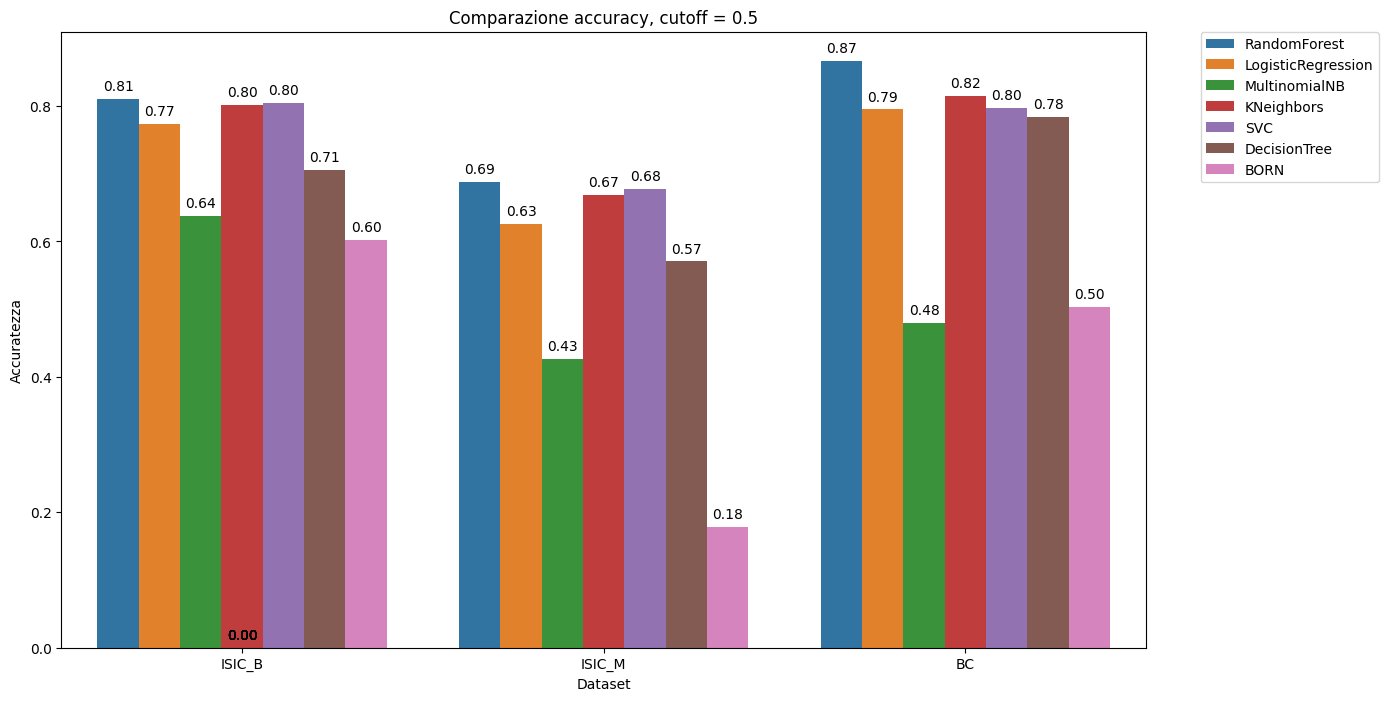

In [ ]:
#PLOT
plt.figure(figsize=(14, 8))
ax = sns.barplot(x='Dataset', y='Accuracy', hue='Classifier', data=df_combined)
plt.title('Comparazione accuracy, cutoff = 0.5')
plt.xlabel('Dataset')
plt.ylabel('Accuratezza')
#annotations
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points')

#legend
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()